In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import fsps
from grizli import multifit
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from grizli.utils import SpectrumTemplate
from scipy.integrate import quad 
import os

import warnings
warnings.simplefilter("ignore")

os.chdir('..')

2024-09-23 15:08:18,981 - stpipe - WARNING - /home/raghav/anaconda3/envs/grizli39/lib/python3.9/site-packages/stsci/__init__.py:7: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('stsci')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)



In [2]:
def L_nu_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    lam_0 = lam / (1 + z) # restframe wavelenth in angstrom
    dust = 10**(-0.4*Av)
    return ((lam_0**2)/(c * m_star)) * l_aa * dust * 3.839E33

def F_nu_per_M(l_aa, lam, z, Av, m_star):
    conv = 3.086E24 # conversion of Mpc to cm
    D_l = cosmo.luminosity_distance(z).value # in Mpc
    return (1 + z) * L_nu_per_M(l_aa, lam, z, Av, m_star)  / (4 * np.pi * (D_l*conv)**2)

def F_lam_per_M(l_aa, lam, z, Av, m_star):
    c = 3E18 # speed of light in angstrom
    return (c / lam**2) * F_nu_per_M(l_aa, lam, z, Av, m_star)

In [3]:
def chi_squared_likelihood_at_age(age, sp, specz, galaxy):
    lam, spec = sp.get_spectrum(tage=age, peraa=True)  
    flam = F_lam_per_M(spec, lam, specz, 0, sp.stellar_mass)  
    tdict = {'a': SpectrumTemplate(lam, flam)}  
    tfit = galaxy.template_at_z(z=specz, templates=tdict)  
    chi_val = tfit['chi2'] / galaxy.DoF  
    return np.exp(-chi_val/2)

In [4]:
def calculate_chi2(ages, sp, specz, galaxy):
    chi = np.zeros_like(ages)  # Initialize chi-square array
    for i, a in enumerate(ages):
        chi[i] = chi_squared_likelihood_at_age(a, sp, specz, galaxy)
    return chi

In [5]:
sp = fsps.StellarPopulation(zcontinuous=1,sfh=4, imf_type=1, logzsol=0.0, dust_type=2, dust2=0.0, add_neb_emission=True)
sp.params['cloudy_dust'] = True
sp.params['gas_logu'] = -3
sp.params['add_igm_absorption'] = True
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True
sp.params['tau'] = 0.1

In [6]:
specz = 1
lam, spec = sp.get_spectrum(tage = 4, peraa=True)
flam = F_lam_per_M(spec, lam, specz, 0, sp.stellar_mass)

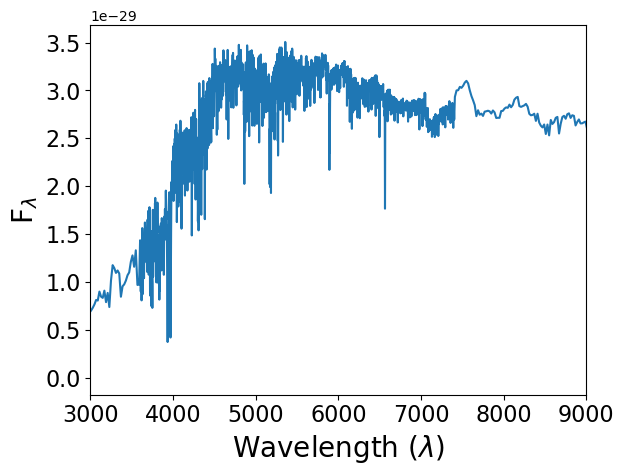

In [7]:
plt.plot(lam, flam)
plt.xlim(3000,9000)
plt.xlabel('Wavelength ($\lambda$)', fontsize = 20)
plt.ylabel('F$_\lambda$', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [8]:
#load the ngdeep_03846 beam
mb_03846 = multifit.MultiBeam('1.0_1.5_updated/ngdeep_03846.beams.fits')

load_master_fits: 1.0_1.5_updated/ngdeep_03846.beams.fits


 !! Shift GR150C.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
1 jw02079004002_11101_00001_nis_rate.fits GR150C
2 jw02079001001_11101_00001_nis_rate.fits GR150C
3 jw02079001001_03101_00002_nis_rate.fits GR150R
4 jw02079004002_03101_00002_nis_rate.fits GR150R
5 jw02079001002_05101_00002_nis_rate.fits GR150C
6 jw02079004001_05101_00002_nis_rate.fits GR150C
 !! Shift GR150R.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
7 jw02079001002_09101_00001_nis_rate.fits GR150R
8 jw02079004001_09101_00001_nis_rate.fits GR150R
9 jw02079004002_05101_00003_nis_rate.fits GR150C
 !! Shift GR150R.F200W.220725.conf along dispersion
10 jw02079001003_03101_00001_nis_rate.fits GR150R
11 jw02079001001_05101_00003_nis_rate.fits GR150C
12 jw02079004001_03101_00003_nis_rate.fits GR150R
 !! Shift GR150C.F200W.220725.conf along dispersion
13 jw02079004003_05101_00001_nis_rate.fits GR150C

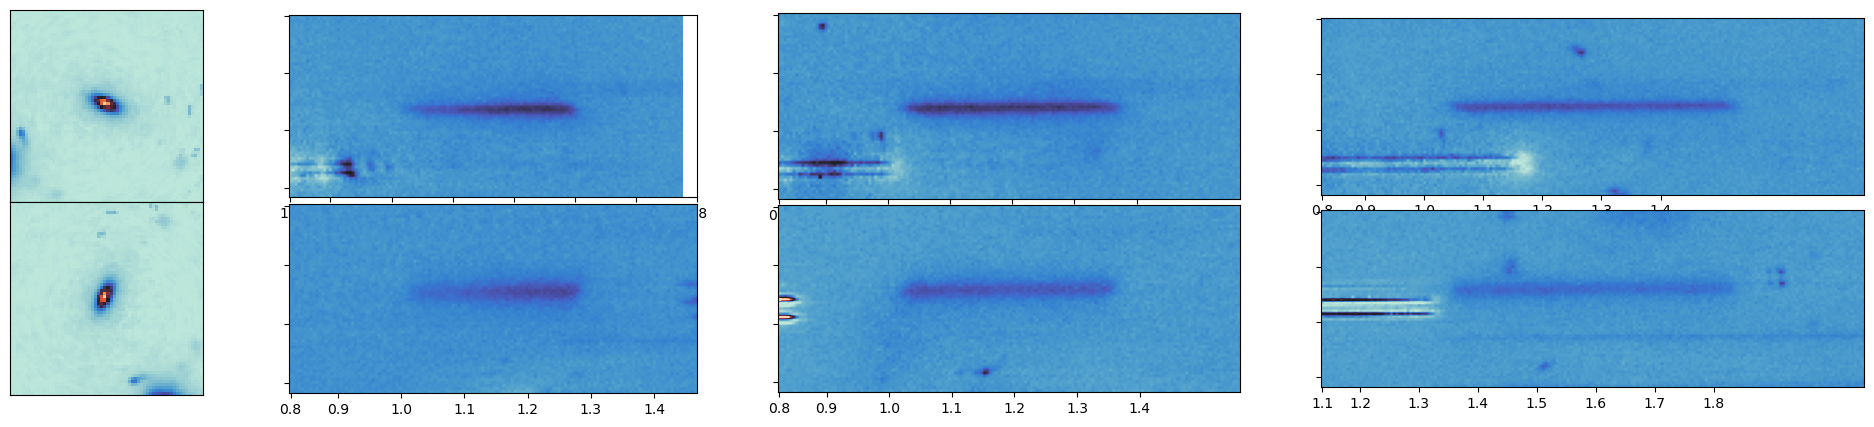

In [9]:
Idict = {}

for b in mb_03846.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'R-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'C-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
for b in mb_03846.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'R-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'C-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))

        
stk_115C = sum(np.array(Idict['F115W-GR150C']) * np.array(Idict['F115W-GR150C_err']) )/sum(np.array(Idict['F115W-GR150C_err'])) 
stk_115R = sum(np.array(Idict['F115W-GR150R']) * np.array(Idict['F115W-GR150R_err']) )/sum(np.array(Idict['F115W-GR150R_err'])) 
stk_150C = sum(np.array(Idict['F150W-GR150C']) * np.array(Idict['F150W-GR150C_err']) )/sum(np.array(Idict['F150W-GR150C_err'])) 
stk_150R = sum(np.array(Idict['F150W-GR150R']) * np.array(Idict['F150W-GR150R_err']) )/sum(np.array(Idict['F150W-GR150R_err'])) 
stk_200C = sum(np.array(Idict['F200W-GR150C']) * np.array(Idict['F200W-GR150C_err']) )/sum(np.array(Idict['F200W-GR150C_err'])) 
stk_200R = sum(np.array(Idict['F200W-GR150R']) * np.array(Idict['F200W-GR150R_err']) )/sum(np.array(Idict['F200W-GR150R_err'])) 

from matplotlib.gridspec import GridSpec
import seaborn as sea
gs = GridSpec(2,4, width_ratios = [0.75,1.5,1.7,2], hspace = 0)
plt.figure(figsize= [24,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[2])
ax10 = plt.subplot(gs[4])
ax11 = plt.subplot(gs[5])
ax12 = plt.subplot(gs[6])
ax13 = plt.subplot(gs[7])


ax0.imshow(Idict['C-GR150C'], vmin = -1E-23, vmax = np.max(Idict['C-GR150C']), cmap = 'icefire')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(stk_115C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03846.beams[0].beam.twod_axis_labels(mpl_axis=ax1)
ax1.set_yticklabels([])

ax2.imshow(stk_150C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03846.beams[2].beam.twod_axis_labels(mpl_axis=ax2)
ax2.set_yticklabels([])

ax3.imshow(stk_200C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03846.beams[4].beam.twod_axis_labels(mpl_axis=ax3)
ax3.set_yticklabels([])  

ax10.imshow(Idict['R-GR150R'], vmin = -1E-23, vmax = np.max(Idict['R-GR150R']), cmap = 'icefire')
ax10.set_xticks([])
ax10.set_yticks([])


ax11.imshow(stk_115R, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03846.beams[1].beam.twod_axis_labels(mpl_axis=ax11)
ax11.set_yticklabels([])

ax12.imshow(stk_150R, cmap = 'icefire', vmin = -0.1, vmax = 0.5  )
mb_03846.beams[10].beam.twod_axis_labels(mpl_axis=ax12)
ax12.set_yticklabels([])

ax13.imshow(stk_200R, cmap = 'icefire', vmin = -0.1, vmax = 0.5 )
mb_03846.beams[6].beam.twod_axis_labels(mpl_axis=ax13)
ax13.set_yticklabels([])  

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03846_GRISM')

In [10]:
ages = [0.1, 0.5, 1, 2, 3, 4, 5, 6]
chi = calculate_chi2(ages, sp, specz, mb_03846)
integrated_chi_likelihood, error = quad(chi_squared_likelihood_at_age, 0.1, 6, args=(sp, specz, mb_03846))
print(integrated_chi_likelihood)

1.4255910311459146


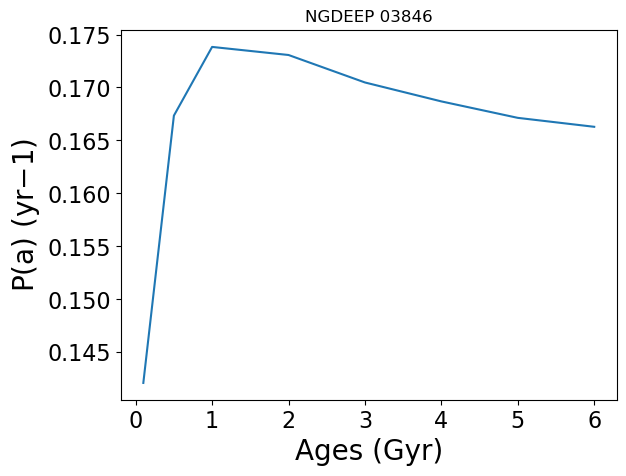

In [11]:
plt.plot(ages,chi/integrated_chi_likelihood)
plt.xlabel('Ages (Gyr)', fontsize = 20)
plt.ylabel('P(a) (yr$-1$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)#load the ngdeep_02981 beam


plt.title("NGDEEP 03846")

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03846_Age',bbox_inches='tight', dpi=150)


In [12]:
#load the ngdeep_03843 beam
mb_03843 = multifit.MultiBeam('1.0_1.5_updated/ngdeep_03843.beams.fits')

load_master_fits: 1.0_1.5_updated/ngdeep_03843.beams.fits
1 jw02079001001_11101_00001_nis_rate.fits GR150C
2 jw02079001001_03101_00002_nis_rate.fits GR150R
3 jw02079004002_03101_00002_nis_rate.fits GR150R
4 jw02079001002_05101_00002_nis_rate.fits GR150C
5 jw02079004001_05101_00002_nis_rate.fits GR150C
 !! Shift GR150R.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
6 jw02079001002_09101_00001_nis_rate.fits GR150R
7 jw02079004001_09101_00001_nis_rate.fits GR150R
8 jw02079004002_05101_00003_nis_rate.fits GR150C
 !! Shift GR150R.F200W.220725.conf along dispersion
9 jw02079001003_03101_00001_nis_rate.fits GR150R
10 jw02079001001_05101_00003_nis_rate.fits GR150C
11 jw02079004001_03101_00003_nis_rate.fits GR150R
 !! Shift GR150C.F200W.220725.conf along dispersion
12 jw02079004003_05101_00001_nis_rate.fits GR150C
13 jw02079001002_03101_00003_nis_rate.fits GR150R
14 jw02079004001_05101_00003_nis_rate.fits GR150C
 !! Shift GR150R.F200W.220725.conf along dispersi

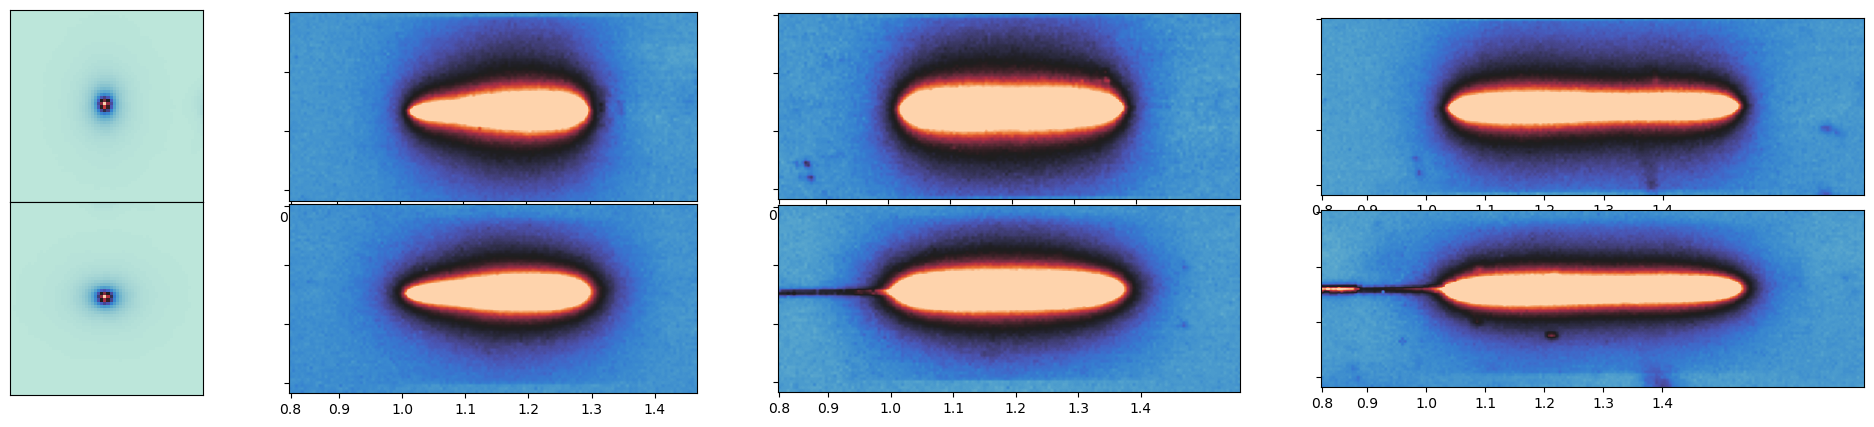

In [13]:
Idict = {}

for b in mb_03843.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'R-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'C-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
for b in mb_03843.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'R-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'C-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))

        
stk_115C = sum(np.array(Idict['F115W-GR150C']) * np.array(Idict['F115W-GR150C_err']) )/sum(np.array(Idict['F115W-GR150C_err'])) 
stk_115R = sum(np.array(Idict['F115W-GR150R']) * np.array(Idict['F115W-GR150R_err']) )/sum(np.array(Idict['F115W-GR150R_err'])) 
stk_150C = sum(np.array(Idict['F150W-GR150C']) * np.array(Idict['F150W-GR150C_err']) )/sum(np.array(Idict['F150W-GR150C_err'])) 
stk_150R = sum(np.array(Idict['F150W-GR150R']) * np.array(Idict['F150W-GR150R_err']) )/sum(np.array(Idict['F150W-GR150R_err'])) 
stk_200C = sum(np.array(Idict['F200W-GR150C']) * np.array(Idict['F200W-GR150C_err']) )/sum(np.array(Idict['F200W-GR150C_err'])) 
stk_200R = sum(np.array(Idict['F200W-GR150R']) * np.array(Idict['F200W-GR150R_err']) )/sum(np.array(Idict['F200W-GR150R_err'])) 

from matplotlib.gridspec import GridSpec
import seaborn as sea
gs = GridSpec(2,4, width_ratios = [0.75,1.5,1.7,2], hspace = 0)
plt.figure(figsize= [24,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[2])
ax10 = plt.subplot(gs[4])
ax11 = plt.subplot(gs[5])
ax12 = plt.subplot(gs[6])
ax13 = plt.subplot(gs[7])


ax0.imshow(Idict['C-GR150C'], vmin = -1E-23, vmax = np.max(Idict['C-GR150C']), cmap = 'icefire')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(stk_115C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03843.beams[0].beam.twod_axis_labels(mpl_axis=ax1)
ax1.set_yticklabels([])

ax2.imshow(stk_150C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03843.beams[2].beam.twod_axis_labels(mpl_axis=ax2)
ax2.set_yticklabels([])

ax3.imshow(stk_200C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03843.beams[4].beam.twod_axis_labels(mpl_axis=ax3)
ax3.set_yticklabels([])  

ax10.imshow(Idict['R-GR150R'], vmin = -1E-23, vmax = np.max(Idict['R-GR150R']), cmap = 'icefire')
ax10.set_xticks([])
ax10.set_yticks([])


ax11.imshow(stk_115R, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03843.beams[1].beam.twod_axis_labels(mpl_axis=ax11)
ax11.set_yticklabels([])

ax12.imshow(stk_150R, cmap = 'icefire', vmin = -0.1, vmax = 0.5  )
mb_03843.beams[10].beam.twod_axis_labels(mpl_axis=ax12)
ax12.set_yticklabels([])

ax13.imshow(stk_200R, cmap = 'icefire', vmin = -0.1, vmax = 0.5 )
mb_03843.beams[6].beam.twod_axis_labels(mpl_axis=ax13)
ax13.set_yticklabels([])  

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03843_GRISM')

In [14]:
ages = [0.1, 0.5, 1, 2, 3, 4, 5, 6]
chi = calculate_chi2(ages, sp, specz, mb_03843)
integrated_chi_likelihood, error = quad(chi_squared_likelihood_at_age, 0.1, 6, args=(sp, specz, mb_03843))
print(integrated_chi_likelihood)

Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: co

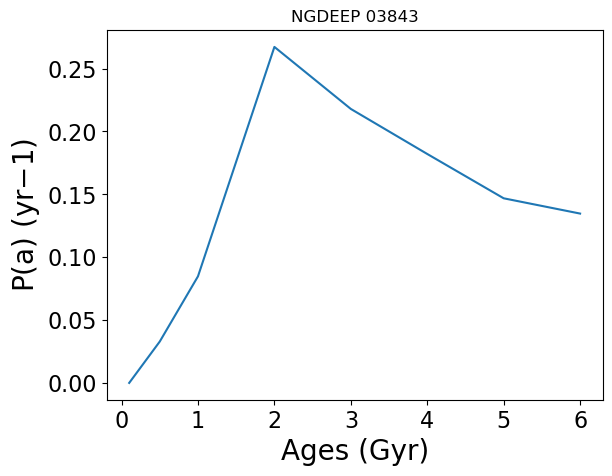

In [15]:
plt.plot(ages,chi/integrated_chi_likelihood)
plt.xlabel('Ages (Gyr)', fontsize = 20)
plt.ylabel('P(a) (yr$-1$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)#load the ngdeep_02981 beam

plt.title("NGDEEP 03843")

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03843_Age',bbox_inches='tight', dpi=150)


In [16]:
#load the ngdeep_03544 beam
mb_03544 = multifit.MultiBeam('1.0_1.5_updated/ngdeep_03544.beams.fits')

load_master_fits: 1.0_1.5_updated/ngdeep_03544.beams.fits
 !! Shift GR150C.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
1 jw02079004002_11101_00001_nis_rate.fits GR150C
2 jw02079001001_11101_00001_nis_rate.fits GR150C
3 jw02079001001_03101_00002_nis_rate.fits GR150R
4 jw02079004002_03101_00002_nis_rate.fits GR150R
5 jw02079001002_05101_00002_nis_rate.fits GR150C
6 jw02079004001_05101_00002_nis_rate.fits GR150C
 !! Shift GR150R.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
7 jw02079001002_09101_00001_nis_rate.fits GR150R
8 jw02079004001_09101_00001_nis_rate.fits GR150R
9 jw02079004002_05101_00003_nis_rate.fits GR150C
 !! Shift GR150R.F200W.220725.conf along dispersion
10 jw02079001003_03101_00001_nis_rate.fits GR150R
11 jw02079001001_05101_00003_nis_rate.fits GR150C
12 jw02079004001_03101_00003_nis_rate.fits GR150R
 !! Shift GR150C.F200W.220725.conf along dispersion
13 jw02079004003_05101_00001_nis_rate.fits GR150C
1

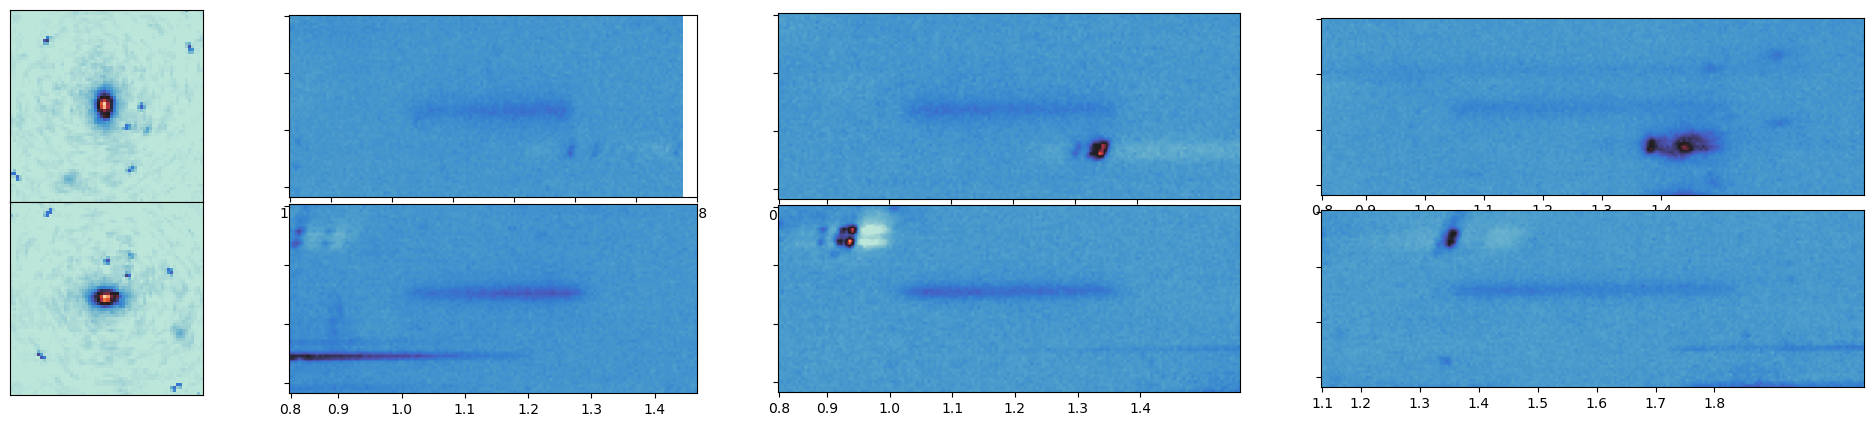

In [17]:
Idict = {}

for b in mb_03544.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'R-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'C-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
for b in mb_03544.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'R-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'C-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))

        
stk_115C = sum(np.array(Idict['F115W-GR150C']) * np.array(Idict['F115W-GR150C_err']) )/sum(np.array(Idict['F115W-GR150C_err'])) 
stk_115R = sum(np.array(Idict['F115W-GR150R']) * np.array(Idict['F115W-GR150R_err']) )/sum(np.array(Idict['F115W-GR150R_err'])) 
stk_150C = sum(np.array(Idict['F150W-GR150C']) * np.array(Idict['F150W-GR150C_err']) )/sum(np.array(Idict['F150W-GR150C_err'])) 
stk_150R = sum(np.array(Idict['F150W-GR150R']) * np.array(Idict['F150W-GR150R_err']) )/sum(np.array(Idict['F150W-GR150R_err'])) 
stk_200C = sum(np.array(Idict['F200W-GR150C']) * np.array(Idict['F200W-GR150C_err']) )/sum(np.array(Idict['F200W-GR150C_err'])) 
stk_200R = sum(np.array(Idict['F200W-GR150R']) * np.array(Idict['F200W-GR150R_err']) )/sum(np.array(Idict['F200W-GR150R_err'])) 

from matplotlib.gridspec import GridSpec
import seaborn as sea
gs = GridSpec(2,4, width_ratios = [0.75,1.5,1.7,2], hspace = 0)
plt.figure(figsize= [24,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[2])
ax10 = plt.subplot(gs[4])
ax11 = plt.subplot(gs[5])
ax12 = plt.subplot(gs[6])
ax13 = plt.subplot(gs[7])


ax0.imshow(Idict['C-GR150C'], vmin = -1E-23, vmax = np.max(Idict['C-GR150C']), cmap = 'icefire')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(stk_115C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03544.beams[0].beam.twod_axis_labels(mpl_axis=ax1)
ax1.set_yticklabels([])

ax2.imshow(stk_150C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03544.beams[2].beam.twod_axis_labels(mpl_axis=ax2)
ax2.set_yticklabels([])

ax3.imshow(stk_200C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03544.beams[4].beam.twod_axis_labels(mpl_axis=ax3)
ax3.set_yticklabels([])  

ax10.imshow(Idict['R-GR150R'], vmin = -1E-23, vmax = np.max(Idict['R-GR150R']), cmap = 'icefire')
ax10.set_xticks([])
ax10.set_yticks([])


ax11.imshow(stk_115R, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03544.beams[1].beam.twod_axis_labels(mpl_axis=ax11)
ax11.set_yticklabels([])

ax12.imshow(stk_150R, cmap = 'icefire', vmin = -0.1, vmax = 0.5  )
mb_03544.beams[10].beam.twod_axis_labels(mpl_axis=ax12)
ax12.set_yticklabels([])

ax13.imshow(stk_200R, cmap = 'icefire', vmin = -0.1, vmax = 0.5 )
mb_03544.beams[6].beam.twod_axis_labels(mpl_axis=ax13)
ax13.set_yticklabels([])  

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03544_GRISM')

In [18]:
ages = [0.1, 0.5, 1, 2, 3, 4, 5, 6]
chi = calculate_chi2(ages, sp, specz, mb_03544)
integrated_chi_likelihood, error = quad(chi_squared_likelihood_at_age, 0.1, 6, args=(sp, specz, mb_03544))
print(integrated_chi_likelihood)

1.4516099850357997


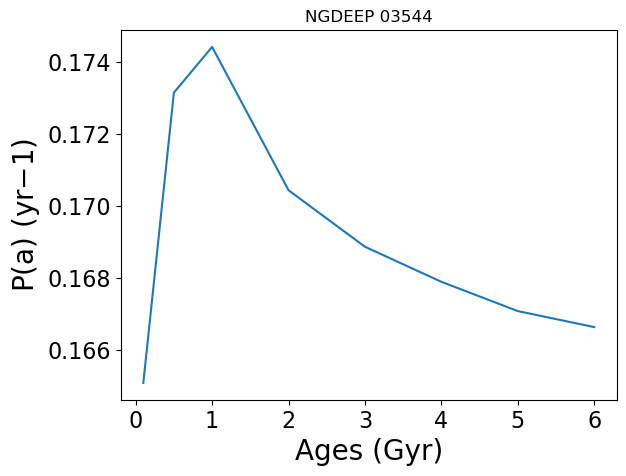

In [19]:
plt.plot(ages,chi/integrated_chi_likelihood)
plt.xlabel('Ages (Gyr)', fontsize = 20)
plt.ylabel('P(a) (yr$-1$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)#load the ngdeep_02981 beam

plt.title("NGDEEP 03544")

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03544_Age',bbox_inches='tight', dpi=150)


In [20]:
#load the ngdeep_03246 beam
mb_03246 = multifit.MultiBeam('1.0_1.5_updated/ngdeep_03246.beams.fits')

load_master_fits: 1.0_1.5_updated/ngdeep_03246.beams.fits
 !! Shift GR150C.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
1 jw02079004002_11101_00001_nis_rate.fits GR150C
2 jw02079001001_11101_00001_nis_rate.fits GR150C
3 jw02079001001_03101_00002_nis_rate.fits GR150R
4 jw02079004002_03101_00002_nis_rate.fits GR150R
5 jw02079001002_05101_00002_nis_rate.fits GR150C
6 jw02079004001_05101_00002_nis_rate.fits GR150C
 !! Shift GR150R.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
7 jw02079001002_09101_00001_nis_rate.fits GR150R
8 jw02079004001_09101_00001_nis_rate.fits GR150R
9 jw02079004002_05101_00003_nis_rate.fits GR150C
 !! Shift GR150R.F200W.220725.conf along dispersion
10 jw02079001003_03101_00001_nis_rate.fits GR150R
11 jw02079001001_05101_00003_nis_rate.fits GR150C
12 jw02079004001_03101_00003_nis_rate.fits GR150R
 !! Shift GR150C.F200W.220725.conf along dispersion
13 jw02079004003_05101_00001_nis_rate.fits GR150C
1

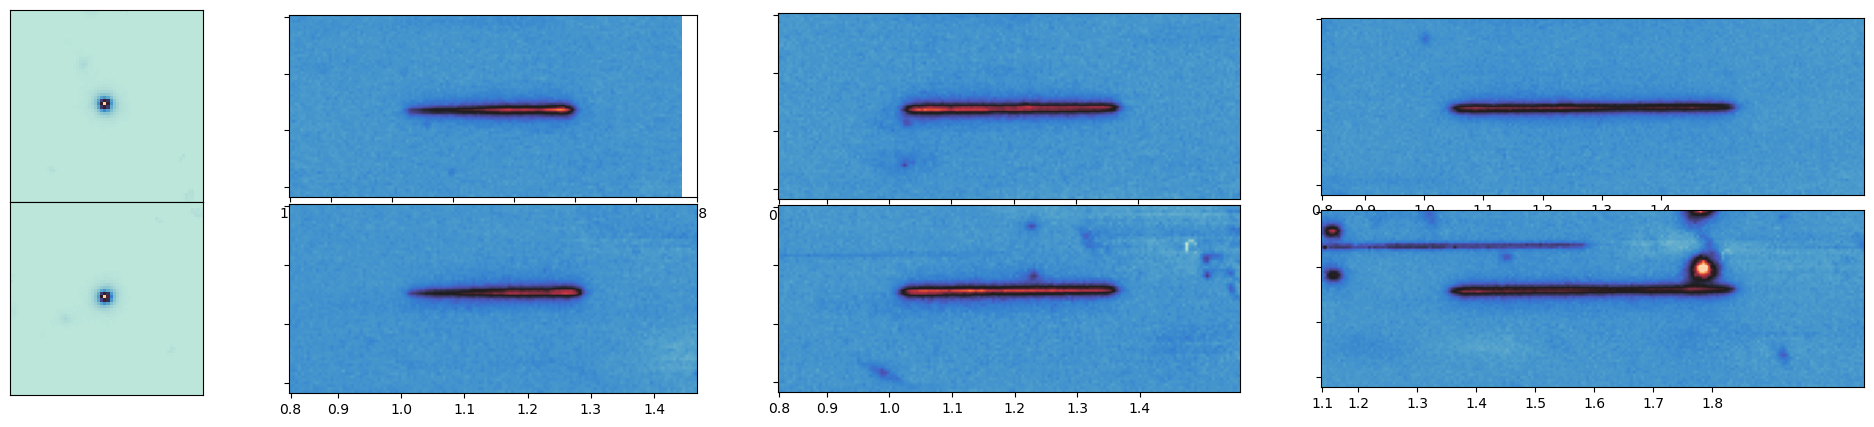

In [21]:
Idict = {}

for b in mb_03246.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'R-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'C-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
for b in mb_03246.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'R-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'C-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))

        
stk_115C = sum(np.array(Idict['F115W-GR150C']) * np.array(Idict['F115W-GR150C_err']) )/sum(np.array(Idict['F115W-GR150C_err'])) 
stk_115R = sum(np.array(Idict['F115W-GR150R']) * np.array(Idict['F115W-GR150R_err']) )/sum(np.array(Idict['F115W-GR150R_err'])) 
stk_150C = sum(np.array(Idict['F150W-GR150C']) * np.array(Idict['F150W-GR150C_err']) )/sum(np.array(Idict['F150W-GR150C_err'])) 
stk_150R = sum(np.array(Idict['F150W-GR150R']) * np.array(Idict['F150W-GR150R_err']) )/sum(np.array(Idict['F150W-GR150R_err'])) 
stk_200C = sum(np.array(Idict['F200W-GR150C']) * np.array(Idict['F200W-GR150C_err']) )/sum(np.array(Idict['F200W-GR150C_err'])) 
stk_200R = sum(np.array(Idict['F200W-GR150R']) * np.array(Idict['F200W-GR150R_err']) )/sum(np.array(Idict['F200W-GR150R_err'])) 

from matplotlib.gridspec import GridSpec
import seaborn as sea
gs = GridSpec(2,4, width_ratios = [0.75,1.5,1.7,2], hspace = 0)
plt.figure(figsize= [24,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[2])
ax10 = plt.subplot(gs[4])
ax11 = plt.subplot(gs[5])
ax12 = plt.subplot(gs[6])
ax13 = plt.subplot(gs[7])


ax0.imshow(Idict['C-GR150C'], vmin = -1E-23, vmax = np.max(Idict['C-GR150C']), cmap = 'icefire')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(stk_115C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03246.beams[0].beam.twod_axis_labels(mpl_axis=ax1)
ax1.set_yticklabels([])

ax2.imshow(stk_150C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03246.beams[2].beam.twod_axis_labels(mpl_axis=ax2)
ax2.set_yticklabels([])

ax3.imshow(stk_200C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03246.beams[4].beam.twod_axis_labels(mpl_axis=ax3)
ax3.set_yticklabels([])  

ax10.imshow(Idict['R-GR150R'], vmin = -1E-23, vmax = np.max(Idict['R-GR150R']), cmap = 'icefire')
ax10.set_xticks([])
ax10.set_yticks([])


ax11.imshow(stk_115R, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_03246.beams[1].beam.twod_axis_labels(mpl_axis=ax11)
ax11.set_yticklabels([])

ax12.imshow(stk_150R, cmap = 'icefire', vmin = -0.1, vmax = 0.5  )
mb_03246.beams[10].beam.twod_axis_labels(mpl_axis=ax12)
ax12.set_yticklabels([])

ax13.imshow(stk_200R, cmap = 'icefire', vmin = -0.1, vmax = 0.5 )
mb_03246.beams[6].beam.twod_axis_labels(mpl_axis=ax13)
ax13.set_yticklabels([])  

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03246_GRISM')

In [22]:
ages = [0.1, 0.5, 1, 2, 3, 4, 5, 6]
chi = calculate_chi2(ages, sp, specz, mb_03246)
integrated_chi_likelihood, error = quad(chi_squared_likelihood_at_age, 0.1, 6, args=(sp, specz, mb_03246))
print(integrated_chi_likelihood)

0.11195461820159161


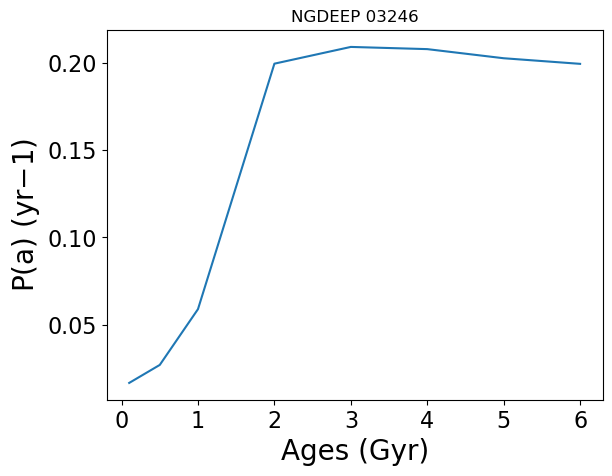

In [23]:
plt.plot(ages, chi/integrated_chi_likelihood)
plt.xlabel('Ages (Gyr)', fontsize = 20)
plt.ylabel('P(a) (yr$-1$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)#load the ngdeep_02981 beam

plt.title("NGDEEP 03246")

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_03246_Age',bbox_inches='tight', dpi=150)


In [24]:
#load the ngdeep_02324 beam
mb_02324 = multifit.MultiBeam('1.0_1.5_updated/ngdeep_02324.beams.fits')

load_master_fits: 1.0_1.5_updated/ngdeep_02324.beams.fits
 !! Shift GR150C.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
1 jw02079004002_11101_00001_nis_rate.fits GR150C
2 jw02079001001_11101_00001_nis_rate.fits GR150C
3 jw02079001001_03101_00002_nis_rate.fits GR150R
4 jw02079004002_03101_00002_nis_rate.fits GR150R
5 jw02079001002_05101_00002_nis_rate.fits GR150C
6 jw02079004001_05101_00002_nis_rate.fits GR150C
 !! Shift GR150R.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
7 jw02079001002_09101_00001_nis_rate.fits GR150R
8 jw02079004001_09101_00001_nis_rate.fits GR150R
9 jw02079004002_05101_00003_nis_rate.fits GR150C
 !! Shift GR150R.F200W.220725.conf along dispersion
10 jw02079001003_03101_00001_nis_rate.fits GR150R
11 jw02079001001_05101_00003_nis_rate.fits GR150C
12 jw02079004001_03101_00003_nis_rate.fits GR150R
 !! Shift GR150C.F200W.220725.conf along dispersion
13 jw02079004003_05101_00001_nis_rate.fits GR150C
1

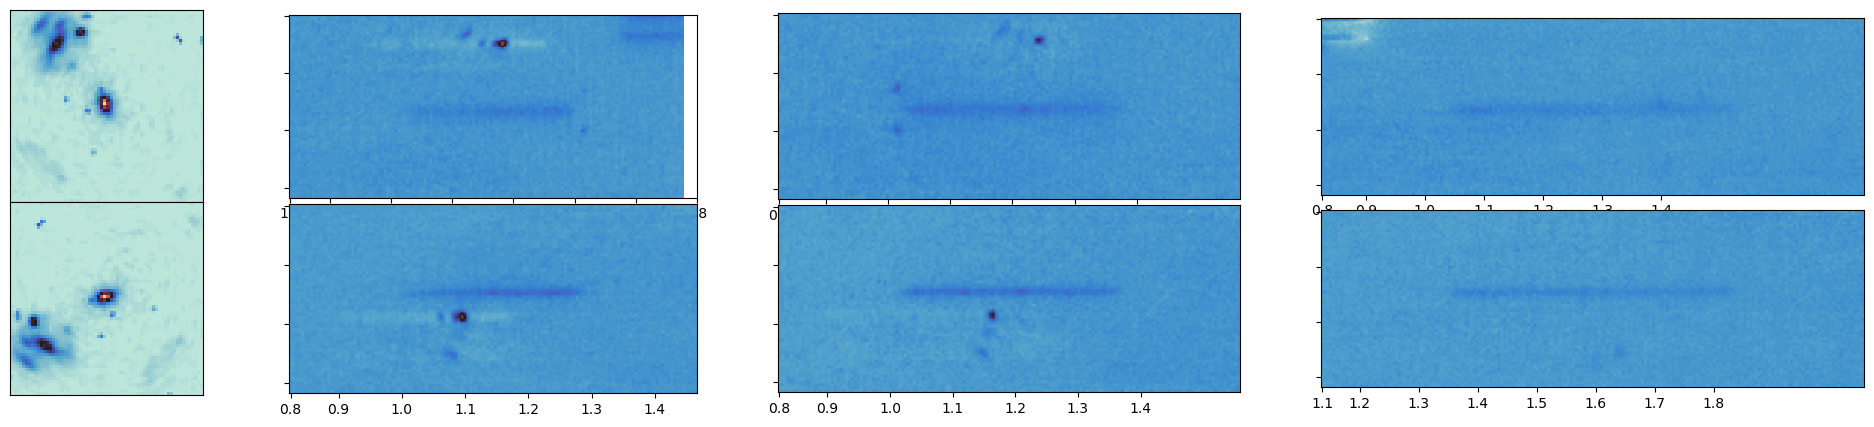

In [25]:
Idict = {}

for b in mb_02324.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'R-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'C-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
for b in mb_02324.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'R-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'C-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))

        
stk_115C = sum(np.array(Idict['F115W-GR150C']) * np.array(Idict['F115W-GR150C_err']) )/sum(np.array(Idict['F115W-GR150C_err'])) 
stk_115R = sum(np.array(Idict['F115W-GR150R']) * np.array(Idict['F115W-GR150R_err']) )/sum(np.array(Idict['F115W-GR150R_err'])) 
stk_150C = sum(np.array(Idict['F150W-GR150C']) * np.array(Idict['F150W-GR150C_err']) )/sum(np.array(Idict['F150W-GR150C_err'])) 
stk_150R = sum(np.array(Idict['F150W-GR150R']) * np.array(Idict['F150W-GR150R_err']) )/sum(np.array(Idict['F150W-GR150R_err'])) 
stk_200C = sum(np.array(Idict['F200W-GR150C']) * np.array(Idict['F200W-GR150C_err']) )/sum(np.array(Idict['F200W-GR150C_err'])) 
stk_200R = sum(np.array(Idict['F200W-GR150R']) * np.array(Idict['F200W-GR150R_err']) )/sum(np.array(Idict['F200W-GR150R_err'])) 

from matplotlib.gridspec import GridSpec
import seaborn as sea
gs = GridSpec(2,4, width_ratios = [0.75,1.5,1.7,2], hspace = 0)
plt.figure(figsize= [24,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[2])
ax10 = plt.subplot(gs[4])
ax11 = plt.subplot(gs[5])
ax12 = plt.subplot(gs[6])
ax13 = plt.subplot(gs[7])


ax0.imshow(Idict['C-GR150C'], vmin = -1E-23, vmax = np.max(Idict['C-GR150C']), cmap = 'icefire')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(stk_115C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_02324.beams[0].beam.twod_axis_labels(mpl_axis=ax1)
ax1.set_yticklabels([])

ax2.imshow(stk_150C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_02324.beams[2].beam.twod_axis_labels(mpl_axis=ax2)
ax2.set_yticklabels([])

ax3.imshow(stk_200C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_02324.beams[4].beam.twod_axis_labels(mpl_axis=ax3)
ax3.set_yticklabels([])  

ax10.imshow(Idict['R-GR150R'], vmin = -1E-23, vmax = np.max(Idict['R-GR150R']), cmap = 'icefire')
ax10.set_xticks([])
ax10.set_yticks([])


ax11.imshow(stk_115R, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_02324.beams[1].beam.twod_axis_labels(mpl_axis=ax11)
ax11.set_yticklabels([])

ax12.imshow(stk_150R, cmap = 'icefire', vmin = -0.1, vmax = 0.5  )
mb_02324.beams[10].beam.twod_axis_labels(mpl_axis=ax12)
ax12.set_yticklabels([])

ax13.imshow(stk_200R, cmap = 'icefire', vmin = -0.1, vmax = 0.5 )
mb_02324.beams[6].beam.twod_axis_labels(mpl_axis=ax13)
ax13.set_yticklabels([])  

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_02324_GRISM')

In [27]:
ages = [0.1, 0.5, 1, 2, 3, 4, 5, 6]
chi = calculate_chi2(ages, sp, specz, mb_02324)
integrated_chi_likelihood, error = quad(chi_squared_likelihood_at_age, 0.1, 6, args=(sp, specz, mb_02324))
print(integrated_chi_likelihood)

1.1613198283593504


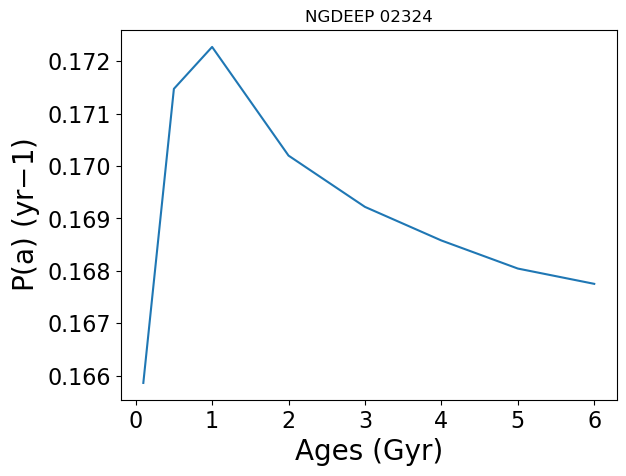

In [28]:
plt.plot(ages,chi/integrated_chi_likelihood)
plt.xlabel('Ages (Gyr)', fontsize = 20)
plt.ylabel('P(a) (yr$-1$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)#load the ngdeep_02981 beam

plt.title("NGDEEP 02324")

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_02324_Age',bbox_inches='tight', dpi=150)


In [29]:
#load the ngdeep_01937 beam
mb_01937 = multifit.MultiBeam('1.0_1.5_updated/ngdeep_01937.beams.fits')

load_master_fits: 1.0_1.5_updated/ngdeep_01937.beams.fits
 !! Shift GR150C.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
1 jw02079004002_11101_00001_nis_rate.fits GR150C
2 jw02079001001_11101_00001_nis_rate.fits GR150C
3 jw02079001001_03101_00002_nis_rate.fits GR150R
4 jw02079004002_03101_00002_nis_rate.fits GR150R
5 jw02079001002_05101_00002_nis_rate.fits GR150C
6 jw02079004001_05101_00002_nis_rate.fits GR150C
 !! Shift GR150R.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
7 jw02079001002_09101_00001_nis_rate.fits GR150R
8 jw02079004001_09101_00001_nis_rate.fits GR150R
9 jw02079004002_05101_00003_nis_rate.fits GR150C
 !! Shift GR150R.F200W.220725.conf along dispersion
10 jw02079001003_03101_00001_nis_rate.fits GR150R
11 jw02079001001_05101_00003_nis_rate.fits GR150C
12 jw02079004001_03101_00003_nis_rate.fits GR150R
 !! Shift GR150C.F200W.220725.conf along dispersion
13 jw02079004003_05101_00001_nis_rate.fits GR150C
1

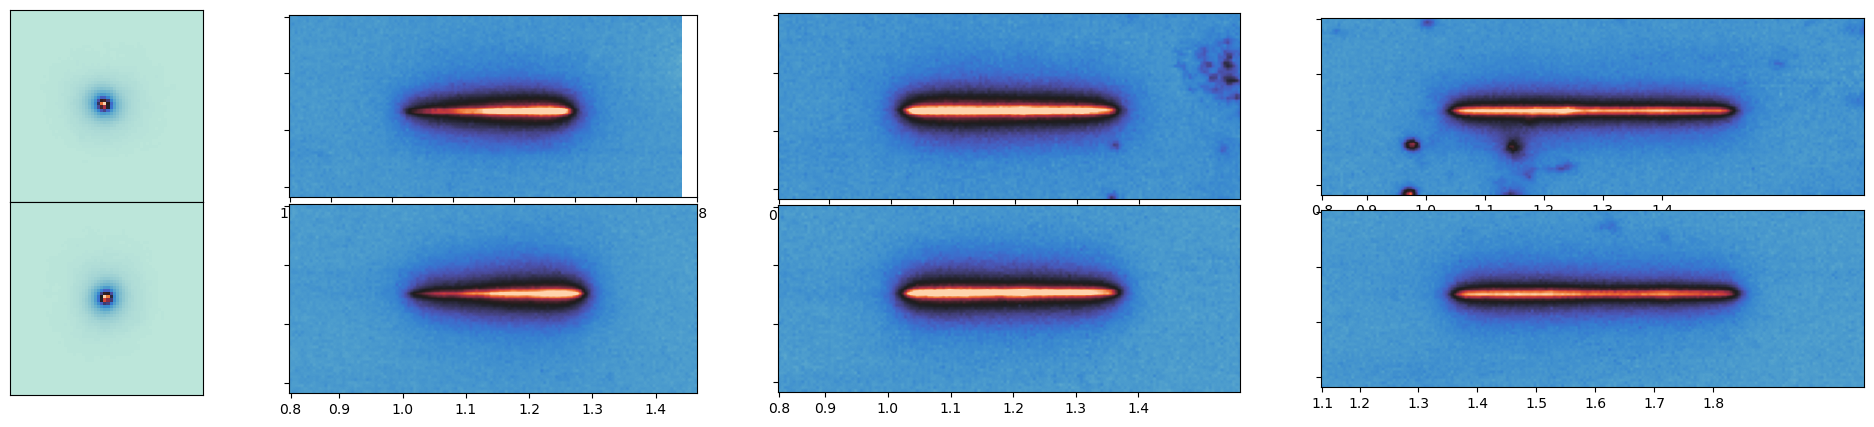

In [30]:
Idict = {}

for b in mb_01937.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'R-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        Idict[f'C-{b.grism.filter}'] = np.zeros(b.beam.sh)
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'] = []
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'] = []
        
for b in mb_01937.beams:
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150R':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F115W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'R-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F150W' and b.grism.filter == 'GR150C':
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
        Idict[f'C-{b.grism.filter}'] += b.beam.direct
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150R': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))
        
    if b.grism.pupil == 'F200W' and b.grism.filter == 'GR150C': 
        Idict[f'{b.grism.pupil}-{b.grism.filter}'].append(b.scif.reshape(b.sh))
        Idict[f'{b.grism.pupil}-{b.grism.filter}_err'].append(np.sqrt(b.ivar))

        
stk_115C = sum(np.array(Idict['F115W-GR150C']) * np.array(Idict['F115W-GR150C_err']) )/sum(np.array(Idict['F115W-GR150C_err'])) 
stk_115R = sum(np.array(Idict['F115W-GR150R']) * np.array(Idict['F115W-GR150R_err']) )/sum(np.array(Idict['F115W-GR150R_err'])) 
stk_150C = sum(np.array(Idict['F150W-GR150C']) * np.array(Idict['F150W-GR150C_err']) )/sum(np.array(Idict['F150W-GR150C_err'])) 
stk_150R = sum(np.array(Idict['F150W-GR150R']) * np.array(Idict['F150W-GR150R_err']) )/sum(np.array(Idict['F150W-GR150R_err'])) 
stk_200C = sum(np.array(Idict['F200W-GR150C']) * np.array(Idict['F200W-GR150C_err']) )/sum(np.array(Idict['F200W-GR150C_err'])) 
stk_200R = sum(np.array(Idict['F200W-GR150R']) * np.array(Idict['F200W-GR150R_err']) )/sum(np.array(Idict['F200W-GR150R_err'])) 

from matplotlib.gridspec import GridSpec
import seaborn as sea
gs = GridSpec(2,4, width_ratios = [0.75,1.5,1.7,2], hspace = 0)
plt.figure(figsize= [24,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[2])
ax10 = plt.subplot(gs[4])
ax11 = plt.subplot(gs[5])
ax12 = plt.subplot(gs[6])
ax13 = plt.subplot(gs[7])


ax0.imshow(Idict['C-GR150C'], vmin = -1E-23, vmax = np.max(Idict['C-GR150C']), cmap = 'icefire')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(stk_115C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_01937.beams[0].beam.twod_axis_labels(mpl_axis=ax1)
ax1.set_yticklabels([])

ax2.imshow(stk_150C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_01937.beams[2].beam.twod_axis_labels(mpl_axis=ax2)
ax2.set_yticklabels([])

ax3.imshow(stk_200C, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_01937.beams[4].beam.twod_axis_labels(mpl_axis=ax3)
ax3.set_yticklabels([])  

ax10.imshow(Idict['R-GR150R'], vmin = -1E-23, vmax = np.max(Idict['R-GR150R']), cmap = 'icefire')
ax10.set_xticks([])
ax10.set_yticks([])


ax11.imshow(stk_115R, cmap = 'icefire', vmin = -0.1,vmax = 0.5 )
mb_01937.beams[1].beam.twod_axis_labels(mpl_axis=ax11)
ax11.set_yticklabels([])

ax12.imshow(stk_150R, cmap = 'icefire', vmin = -0.1, vmax = 0.5  )
mb_01937.beams[10].beam.twod_axis_labels(mpl_axis=ax12)
ax12.set_yticklabels([])

ax13.imshow(stk_200R, cmap = 'icefire', vmin = -0.1, vmax = 0.5 )
mb_01937.beams[6].beam.twod_axis_labels(mpl_axis=ax13)
ax13.set_yticklabels([])  

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_01937_GRISM')

In [31]:
ages = [0.1, 0.5, 1, 2, 3, 4, 5, 6]
chi = calculate_chi2(ages, sp, specz, mb_01937)
integrated_chi_likelihood, error = quad(chi_squared_likelihood_at_age, 0.1, 6, args=(sp, specz, mb_01937))
print(integrated_chi_likelihood)

Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: covar!
Except: co

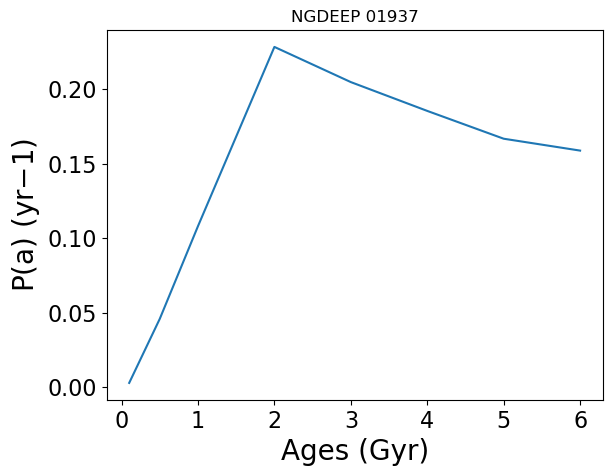

In [32]:
plt.plot(ages,chi/integrated_chi_likelihood)
plt.xlabel('Ages (Gyr)', fontsize = 20)
plt.ylabel('P(a) (yr$-1$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)#load the ngdeep_02981 beam

plt.title("NGDEEP 01937")

plt.savefig('fitting_graphs/1.0_1.5/NGDEEP_01937_Age',bbox_inches='tight', dpi=150)